In [1]:
import face_recognition
from face_recognition import face_locations
import os
import pandas as pd
import h5py
from tqdm import tqdm
from recursive_dict import *
import scipy.io
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split


In [2]:
# set data paths
data_dir = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/LWFA+'
img_dir = os.path.join(data_dir, 'lfw/merge_folder')
indices_path = os.path.join(data_dir, 'indices_train_test.mat')
attr_path = os.path.join(data_dir, 'lfw_att_73.mat')

In [3]:
label_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/LWFA+/label.mat'
label = scipy.io.loadmat(label_mat)['label']

name_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/LWFA+/name.mat'
name = scipy.io.loadmat(name_mat)['name']
name = [s[0].split('\\')[1] for s in name.tolist()[0]]

attr_name_mat = '/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/LWFA+/attrname.mat'
attr_name = scipy.io.loadmat(attr_name_mat)['AttrName']
attr_name = [str(s[0]) for s in attr_name.tolist()[0]]

In [4]:
df_label = pd.DataFrame(label, columns=attr_name, index=name)

In [5]:
df_label

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Eckhart_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
Aaron_Guiel_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
Aaron_Patterson_0001.jpg,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,1,0,1,0
Aaron_Peirsol_0001.jpg,1,0,1,0,0,0,1,1,0,0,...,1,0,1,0,0,1,1,0,1,0
Aaron_Peirsol_0002.jpg,1,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zorica_Radovic_0001.jpg,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
Zulfiqar_Ahmed_0001.jpg,1,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,1,0
Zumrati_Juma_0001.jpg,0,0,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,0
Zurab_Tsereteli_0001.jpg,1,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,1,0


In [6]:
df_label.index

Index(['Aaron_Eckhart_0001.jpg', 'Aaron_Guiel_0001.jpg',
       'Aaron_Patterson_0001.jpg', 'Aaron_Peirsol_0001.jpg',
       'Aaron_Peirsol_0002.jpg', 'Aaron_Peirsol_0003.jpg',
       'Aaron_Peirsol_0004.jpg', 'Aaron_Pena_0001.jpg',
       'Aaron_Sorkin_0001.jpg', 'Aaron_Sorkin_0002.jpg',
       ...
       'Zoe_Ball_0001.jpg', 'Zoran_Djindjic_0001.jpg',
       'Zoran_Djindjic_0002.jpg', 'Zoran_Djindjic_0003.jpg',
       'Zoran_Djindjic_0004.jpg', 'Zorica_Radovic_0001.jpg',
       'Zulfiqar_Ahmed_0001.jpg', 'Zumrati_Juma_0001.jpg',
       'Zurab_Tsereteli_0001.jpg', 'Zydrunas_Ilgauskas_0001.jpg'],
      dtype='object', length=13143)

In [138]:
# extract face features using face_recognition.face_encodings
# take about 10 minutes on my pc
feature_vecs = []
fnames = []
for fname in tqdm(df_label.index):
    img_path = os.path.join(img_dir, fname)
    # face detection
    X_img = face_recognition.load_image_file(img_path)
    X_faces_loc = face_locations(X_img)
    # if the number of faces detected in a image is not 1, ignore the image
    if len(X_faces_loc) != 1:
        continue
    # extract 128 dimensional face features
    faces_encoding = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)[0]
    feature_vecs.append(faces_encoding)
    fnames.append(fname)
df_feat = pd.DataFrame(feature_vecs, index=fnames)
df_label = df_label[df_label.index.isin(df_feat.index)]
df_feat.sort_index(inplace=True)
df_label.sort_index(inplace=True)

df_feat.to_csv('feature.csv')
df_label.to_csv('label.csv')


  0%|                                                 | 0/12264 [00:00<?, ?it/s]


TypeError: 'list' object is not callable

In [137]:
len(X_faces_loc)

1

In [8]:
# load features and labels
df_feat = pd.read_csv('feature.csv', index_col=0)
df_label = pd.read_csv('label.csv', index_col=0)

In [9]:
# split training/test name
unique_names = list(set([path.split('/')[0] for path in df_feat.index]))
name_train, name_test = train_test_split(unique_names, test_size = 0.1, random_state = 0)
name_train, name_test = set(name_train), set(name_test)
# split training/test images
idx_train = [path.split('/')[0] in name_train for path in df_feat.index]
idx_test = [path.split('/')[0] in name_test for path in df_feat.index]
X_train, Y_train = df_feat[idx_train], df_label[idx_train]
X_test, Y_test = df_feat[idx_test], df_label[idx_test]

In [38]:
X_train.shape

(11037, 128)

In [10]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
Aaron_Sorkin_0002.jpg,-0.093324,0.144733,0.026938,-0.004890,-0.127102,-0.005833,-0.011295,-0.110027,0.200945,0.023984,...,0.047516,-0.024437,-0.011253,0.017250,-0.086503,-0.097349,0.042236,-0.022375,0.073528,-0.025943
Abdullah_0002.jpg,-0.153335,0.096666,0.039910,0.027883,-0.077283,-0.066857,-0.034785,-0.075760,0.174534,-0.073543,...,0.003567,0.069401,-0.050030,0.090377,-0.079001,-0.153059,0.005715,-0.094104,0.099102,0.039336
Abdullah_Ahmad_Badawi_0001.jpg,-0.046264,0.064001,0.018449,-0.076954,-0.062372,-0.122302,0.024790,-0.104918,0.055007,0.039318,...,0.137733,0.038741,-0.022753,-0.011673,-0.112853,-0.131088,0.065272,0.009252,0.054837,0.086569
Abdullah_Gul_0007.jpg,-0.037081,-0.029424,0.053423,-0.037758,-0.018850,-0.128242,0.061337,-0.095239,0.086862,-0.083206,...,0.030171,0.006726,0.011045,0.039706,-0.126092,-0.100580,-0.019940,0.041953,0.020309,-0.026729
Adrianna_Zuzic_0001.jpg,-0.096136,0.138214,0.085425,-0.126057,-0.124977,-0.009414,-0.035626,-0.106788,0.218321,-0.152696,...,0.014098,0.024839,0.041210,-0.173382,-0.127130,-0.070054,0.151033,0.003835,0.027612,0.006232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zakia_Hakki_0001.jpg,-0.124104,0.063091,0.133308,-0.057266,-0.066678,-0.065626,-0.039352,-0.209317,0.123725,-0.164702,...,0.075993,0.017618,-0.039481,-0.005513,-0.168361,-0.041629,0.065174,0.054815,0.027647,0.005103
Zdravko_Mucic_0001.jpg,-0.093563,0.039368,0.007257,-0.089917,-0.045156,-0.086741,-0.018097,-0.027655,0.150215,-0.026743,...,0.121105,0.012748,-0.014183,0.043645,-0.075440,-0.119338,0.056440,0.067595,0.087394,0.095058
Zelma_Novelo_0001.jpg,-0.124883,0.031767,0.051021,-0.052170,-0.118699,-0.037682,0.014666,-0.093581,0.217926,-0.111194,...,0.046000,-0.016239,0.031736,-0.038357,-0.111856,-0.134541,0.042586,-0.064370,-0.007719,-0.098364
Zhu_Rongji_0003.jpg,-0.064241,0.082620,0.010610,0.039137,-0.097494,-0.095973,-0.014834,-0.142342,0.106692,-0.069932,...,0.107530,0.095409,-0.004340,0.006496,-0.155327,-0.099411,0.070643,0.069341,0.087765,-0.030006


In [11]:
model = MLPClassifier(solver='adam', hidden_layer_sizes=(128, 128),max_iter = 5000, verbose=True, tol=1e-4, activation='relu')
model.fit(X_train, Y_train)
prediction = model.predict(X_test)
prediction_score = model.predict_proba(X_test)

df_prediction = pd.DataFrame(prediction, columns=df_label.columns, index=Y_test.index)
df_prediction_score = pd.DataFrame(prediction_score, columns=df_label.columns, index=Y_test.index)

Iteration 1, loss = 40.55505115
Iteration 2, loss = 35.01486540
Iteration 3, loss = 32.80020369
Iteration 4, loss = 31.86628511
Iteration 5, loss = 31.18377263
Iteration 6, loss = 30.86348514
Iteration 7, loss = 30.64867361
Iteration 8, loss = 30.45726216
Iteration 9, loss = 30.26188819
Iteration 10, loss = 30.09992800
Iteration 11, loss = 29.92504448
Iteration 12, loss = 29.76504584
Iteration 13, loss = 29.61712170
Iteration 14, loss = 29.49745461
Iteration 15, loss = 29.37120372
Iteration 16, loss = 29.27182714
Iteration 17, loss = 29.19783410
Iteration 18, loss = 29.12940098
Iteration 19, loss = 29.03716732
Iteration 20, loss = 28.97161788
Iteration 21, loss = 28.91731203
Iteration 22, loss = 28.86143591
Iteration 23, loss = 28.81597368
Iteration 24, loss = 28.76871639
Iteration 25, loss = 28.73923163
Iteration 26, loss = 28.68023172
Iteration 27, loss = 28.64814941
Iteration 28, loss = 28.62069541
Iteration 29, loss = 28.59042503
Iteration 30, loss = 28.56087722
Iteration 31, loss 

Iteration 246, loss = 25.95888143
Iteration 247, loss = 25.92165057
Iteration 248, loss = 25.93381669
Iteration 249, loss = 25.90630890
Iteration 250, loss = 25.89713242
Iteration 251, loss = 25.88895169
Iteration 252, loss = 25.87932661
Iteration 253, loss = 25.88702758
Iteration 254, loss = 25.93089876
Iteration 255, loss = 25.87932929
Iteration 256, loss = 25.88093046
Iteration 257, loss = 25.85330705
Iteration 258, loss = 25.87185732
Iteration 259, loss = 25.84848370
Iteration 260, loss = 25.83276556
Iteration 261, loss = 25.82117281
Iteration 262, loss = 25.83847922
Iteration 263, loss = 25.82891513
Iteration 264, loss = 25.82446627
Iteration 265, loss = 25.79364667
Iteration 266, loss = 25.80053063
Iteration 267, loss = 25.82350244
Iteration 268, loss = 25.78666421
Iteration 269, loss = 25.82509286
Iteration 270, loss = 25.77725670
Iteration 271, loss = 25.79564402
Iteration 272, loss = 25.79344247
Iteration 273, loss = 25.78592144
Iteration 274, loss = 25.76924083
Iteration 275,

Iteration 487, loss = 24.90385952
Iteration 488, loss = 24.89576434
Iteration 489, loss = 24.90479204
Iteration 490, loss = 24.90379615
Iteration 491, loss = 24.86907431
Iteration 492, loss = 24.91045761
Iteration 493, loss = 24.89416327
Iteration 494, loss = 24.91032938
Iteration 495, loss = 24.87441293
Iteration 496, loss = 24.86555822
Iteration 497, loss = 24.85608547
Iteration 498, loss = 24.85365458
Iteration 499, loss = 24.87661702
Iteration 500, loss = 24.89388772
Iteration 501, loss = 24.84215840
Iteration 502, loss = 24.87845358
Iteration 503, loss = 24.86152271
Iteration 504, loss = 24.86263594
Iteration 505, loss = 24.87370027
Iteration 506, loss = 24.81766503
Iteration 507, loss = 24.83056013
Iteration 508, loss = 24.84519518
Iteration 509, loss = 24.82563205
Iteration 510, loss = 24.90644140
Iteration 511, loss = 24.82949830
Iteration 512, loss = 24.80167907
Iteration 513, loss = 24.82363931
Iteration 514, loss = 24.81065132
Iteration 515, loss = 24.82827570
Iteration 516,

Iteration 728, loss = 24.34290980
Iteration 729, loss = 24.31309972
Iteration 730, loss = 24.34389864
Iteration 731, loss = 24.33708552
Iteration 732, loss = 24.33067167
Iteration 733, loss = 24.33092056
Iteration 734, loss = 24.34275539
Iteration 735, loss = 24.31419733
Iteration 736, loss = 24.31166178
Iteration 737, loss = 24.33745505
Iteration 738, loss = 24.30244851
Iteration 739, loss = 24.32370820
Iteration 740, loss = 24.33899162
Iteration 741, loss = 24.30424694
Iteration 742, loss = 24.29168548
Iteration 743, loss = 24.30947756
Iteration 744, loss = 24.33668048
Iteration 745, loss = 24.38158610
Iteration 746, loss = 24.29688495
Iteration 747, loss = 24.31809975
Iteration 748, loss = 24.30366126
Iteration 749, loss = 24.30209235
Iteration 750, loss = 24.31686427
Iteration 751, loss = 24.33896796
Iteration 752, loss = 24.28280590
Iteration 753, loss = 24.25534433
Iteration 754, loss = 24.27462028
Iteration 755, loss = 24.30666866
Iteration 756, loss = 24.32745921
Iteration 757,

In [12]:
print(prediction_score)

[[8.22949055e-01 5.79866555e-03 7.13707472e-01 ... 9.13138473e-02
  4.04986104e-01 6.22373041e-01]
 [9.73742661e-01 1.78012891e-02 1.64821500e-01 ... 5.50998788e-03
  5.21394533e-01 1.01915561e-01]
 [9.94551399e-01 6.05680608e-01 1.03325240e-01 ... 1.15852805e-03
  8.01155521e-01 2.56037159e-03]
 ...
 [1.89877915e-02 3.09024680e-03 7.47597454e-01 ... 7.25921269e-01
  5.77456039e-02 7.46494779e-01]
 [9.87024996e-01 9.97613107e-01 6.13086523e-02 ... 4.69637441e-04
  8.50505894e-01 5.57187268e-03]
 [9.87275671e-01 7.90792360e-01 1.05790792e-02 ... 3.78547651e-03
  9.32553395e-01 2.12283290e-02]]


In [13]:
df_prediction

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Sorkin_0002.jpg,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
Abdullah_0002.jpg,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
Abdullah_Ahmad_Badawi_0001.jpg,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
Abdullah_Gul_0007.jpg,1,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
Adrianna_Zuzic_0001.jpg,1,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zakia_Hakki_0001.jpg,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,0,0,1
Zdravko_Mucic_0001.jpg,1,0,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,1,0,1,0
Zelma_Novelo_0001.jpg,0,0,1,0,0,0,1,0,0,0,...,0,0,1,1,0,1,1,1,0,1
Zhu_Rongji_0003.jpg,1,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,1,0,1,0


In [14]:
pd.set_option("display.max_rows", 999)
df_prediction_score

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
Aaron_Sorkin_0002.jpg,0.822949,0.005799,0.713707,0.003561,0.000105,0.034464,0.309104,0.120505,0.004513,0.174764,...,0.373371,0.479904,0.899153,0.068425,0.079804,0.853036,0.801066,0.091314,0.404986,0.622373
Abdullah_0002.jpg,0.973743,0.017801,0.164822,0.015092,0.001622,0.024680,0.026007,0.171694,0.004076,0.286697,...,0.226350,0.959115,0.389877,0.008308,0.069578,0.027476,0.942603,0.005510,0.521395,0.101916
Abdullah_Ahmad_Badawi_0001.jpg,0.994551,0.605681,0.103325,0.003477,0.000204,0.012895,0.074778,0.140698,0.023407,0.283359,...,0.453274,0.746272,0.045669,0.002807,0.051099,0.011454,0.963802,0.001159,0.801156,0.002560
Abdullah_Gul_0007.jpg,0.997265,0.003728,0.708063,0.006149,0.000350,0.001247,0.001212,0.311783,0.059032,0.045964,...,0.320924,0.903777,0.845339,0.001865,0.062248,0.200582,0.947556,0.000916,0.911113,0.030223
Adrianna_Zuzic_0001.jpg,0.929802,0.002553,0.969425,0.000420,0.004496,0.034074,0.519713,0.033258,0.001932,0.046559,...,0.559021,0.344848,0.059642,0.029126,0.065835,0.016204,0.319416,0.022893,0.202757,0.105936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zakia_Hakki_0001.jpg,0.055740,0.033211,0.451556,0.003985,0.000628,0.026377,0.082187,0.031250,0.090699,0.171605,...,0.589262,0.017493,0.652537,0.723500,0.112398,0.642456,0.599766,0.414577,0.287031,0.649582
Zdravko_Mucic_0001.jpg,0.995510,0.011316,0.861165,0.001991,0.001451,0.113930,0.019895,0.264669,0.029006,0.153417,...,0.543765,0.887608,0.197087,0.005605,0.077335,0.015902,0.921365,0.000692,0.542201,0.033258
Zelma_Novelo_0001.jpg,0.018988,0.003090,0.747597,0.007123,0.003626,0.108276,0.634301,0.034222,0.000599,0.355103,...,0.237969,0.014182,0.899190,0.564384,0.047863,0.781492,0.860527,0.725921,0.057746,0.746495
Zhu_Rongji_0003.jpg,0.987025,0.997613,0.061309,0.000945,0.000263,0.018828,0.018161,0.006093,0.868877,0.251065,...,0.564763,0.070938,0.889890,0.004561,0.051650,0.711901,0.982560,0.000470,0.850506,0.005572


In [15]:
df_prediction_score.to_csv('score.csv')

In [70]:
# save model
import pickle
save_path = 'model.pkl'
with open(save_path, 'wb') as f:
    pickle.dump(model, f)
    
# pickle.dump(model,save_path)

In [18]:
def plot_roc(attr, target, score):
    """Plot a ROC curve and show the accuracy score and the AUC"""
    fig, ax = plt.subplots()
    auc = roc_auc_score(target, score)
    acc = accuracy_score(target, (score >= 0.5).astype(int))
    fpr, tpr, _ = roc_curve(target, score)
    plt.plot(fpr, tpr, lw = 2, label = attr.title())
    plt.legend(loc = 4, fontsize = 15)
    plt.title(('ROC Curve for {attr} (Accuracy = {acc:.3f}, AUC = {auc:.3f})'
               .format(attr = attr.title(), acc= acc, auc = auc)),
              fontsize = 15)
    plt.xlabel('False Positive Rate', fontsize = 15)
    plt.ylabel('True Positive Rate', fontsize = 15)
    plt.show()
    return fig

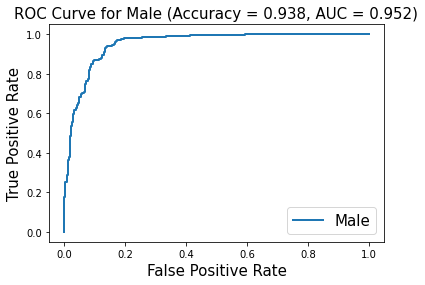

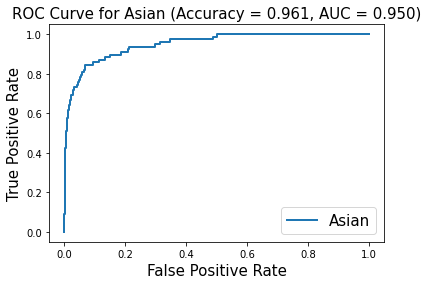

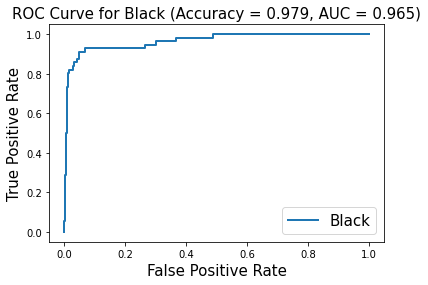

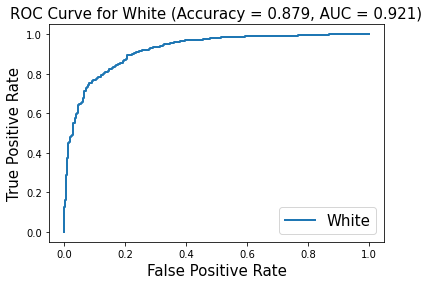

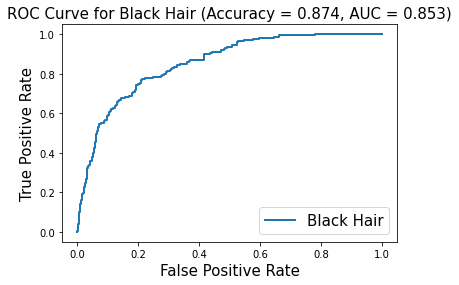

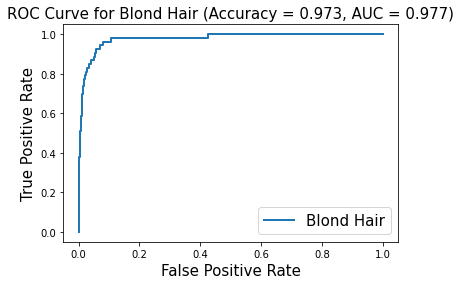

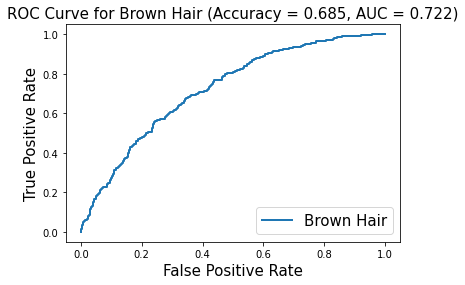

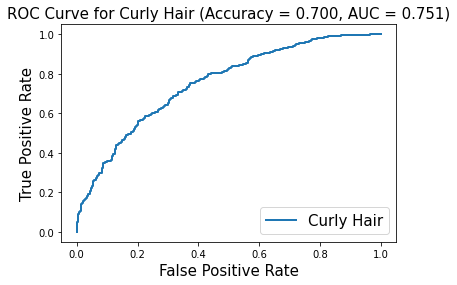

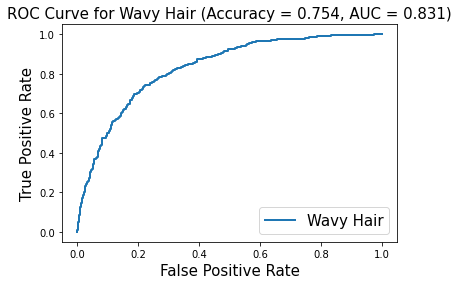

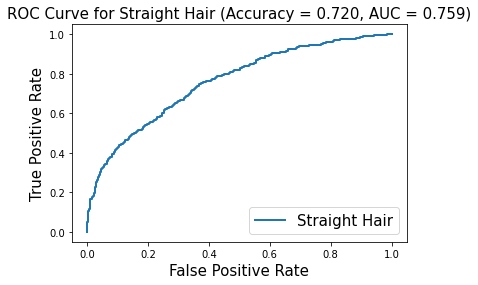

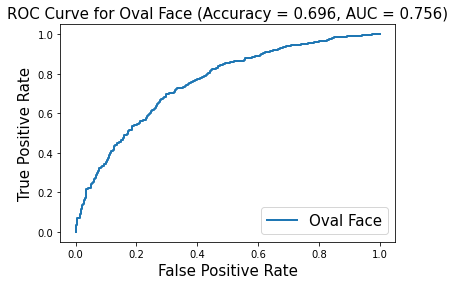

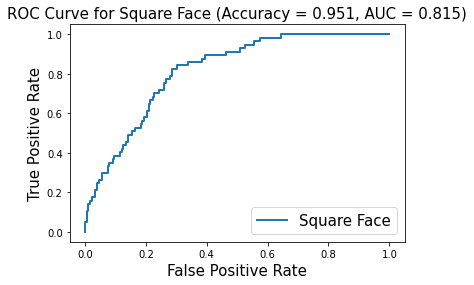

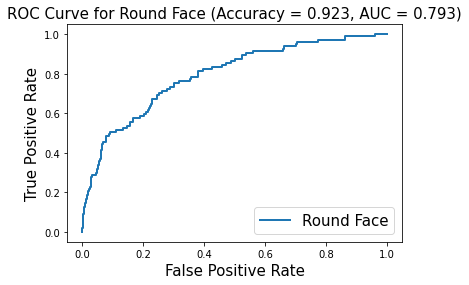

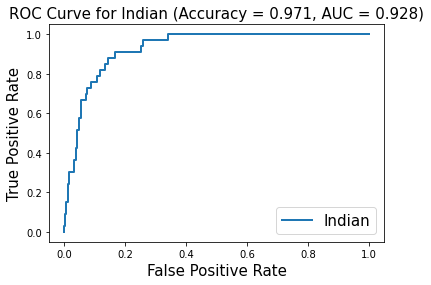

In [19]:
# plot ROC curves
cols = ['Male', 'Asian', 'Black', 'White','Black Hair','Blond Hair','Brown Hair','Curly Hair','Wavy Hair','Straight Hair','Oval Face','Square Face','Round Face','Indian']
for attr in cols:
    target = Y_test[attr]
    score = df_prediction_score[attr]
    fig = plot_roc(attr, target, score)

In [108]:
import pickle
loaded_model = pickle.load(open('model.pkl', 'rb'))


In [44]:
loaded_model

MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=5000, verbose=True)

In [110]:
feature_vecs_target = []

In [111]:
image = face_recognition.load_image_file("/Users/arthur/Downloads/170757634_10.jpeg")
face_locations = face_recognition.face_locations(image)
faces_encoding = face_recognition.face_encodings(image, known_face_locations=X_faces_loc)[0]
feature_vecs_target.append(faces_encoding)

In [35]:
FichList = [ f for f in os.listdir('/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/df_2') if os.path.isfile(os.path.join('/Users/arthur/Desktop/2022 EM/Machine Learning/Projet/DB + Model/df_2',f)) ]
print(FichList)

['téléchargement (8).jpeg', 'téléchargement.jpeg', 'téléchargement (5).jpeg', 'téléchargement (7).jpeg', 'téléchargement (3).jpeg', 'téléchargement (1).jpeg', 'téléchargement (6).jpeg', 'téléchargement (4).jpeg', 'téléchargement (2).jpeg']


In [112]:
loaded_model.predict(feature_vecs_target)

/opt/anaconda3/envs/emlyon/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


array([[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 1, 0, 0, 0]])

In [118]:
prediction_score2 = loaded_model.predict_proba(feature_vecs_target)

/opt/anaconda3/envs/emlyon/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [119]:
df_2 = pd.DataFrame(prediction_score2, columns=df_label.columns)

In [120]:
df_2

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,0.877844,0.065265,0.742413,0.046249,0.005016,0.088881,0.113637,0.005384,0.060664,0.014475,...,0.524754,0.256987,0.261297,0.059892,0.154227,0.088008,0.589607,0.023264,0.396961,0.212112
